# Bike Pattern

We used a little bit of machine learning on [Divvy Data](https://www.divvybikes.com/system-data) to dig into a better division of Chicago. We try to identify patterns among bike stations.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## The data

[Divvy Data](https://www.divvybikes.com/system-data) publishes a sample of the data. 

In [3]:
from pyensae.datasource import download_data
file = download_data("Divvy_Trips_2016_Q3Q4.zip", url="https://s3.amazonaws.com/divvy-data/tripdata/")

We know the stations.

In [4]:
import pandas
stations = pandas.read_csv("Divvy_Stations_2016_Q3.csv")
bikes = pandas.concat([pandas.read_csv("Divvy_Trips_2016_Q3.csv"),
                       pandas.read_csv("Divvy_Trips_2016_Q4.csv")])

In [5]:
from datetime import datetime, time
df = bikes
df["dtstart"] = pandas.to_datetime(df.starttime, infer_datetime_format=True)
df["dtstop"] = pandas.to_datetime(df.stoptime, infer_datetime_format=True)
df["stopday"] = df.dtstop.apply(lambda r: datetime(r.year, r.month, r.day))
df["stoptime"] = df.dtstop.apply(lambda r: time(r.hour, r.minute, 0))
df["stoptime10"] = df.dtstop.apply(lambda r: time(r.hour, (r.minute // 10)*10, 0))  # every 10 minutes

In [6]:
df['stopweekday'] = df['dtstop'].dt.dayofweek

## Normalize per week day (stop)

In [7]:
df.columns

Index(['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear', 'dtstart',
       'dtstop', 'stopday', 'stoptime10', 'stopweekday'],
      dtype='object')

In [8]:
key = ["to_station_id", "to_station_name", "stopweekday", "stoptime10"]
keep = key + ["trip_id"]
aggtime = df[keep].groupby(key, as_index=False).count()
aggtime.columns = key + ["nb_trips"]
aggtime.head()

,to_station_id,to_station_name,stopweekday,stoptime10,nb_trips
0,2,Michigan Ave & Balbo Ave,0,00:10:00,2
1,2,Michigan Ave & Balbo Ave,0,00:20:00,2
2,2,Michigan Ave & Balbo Ave,0,00:30:00,2
3,2,Michigan Ave & Balbo Ave,0,01:00:00,3
4,2,Michigan Ave & Balbo Ave,0,01:10:00,2


In [9]:
aggday = df[keep[:-2] + ["trip_id"]].groupby(key[:-1], as_index=False).count()
aggday.columns = key[:-1] + ["nb_trips"]
aggday.sort_values("nb_trips", ascending=False).head()

,to_station_id,to_station_name,stopweekday,nb_trips
222,35,Streeter Dr & Grand Ave,5,15380
223,35,Streeter Dr & Grand Ave,6,14680
217,35,Streeter Dr & Grand Ave,0,9228
221,35,Streeter Dr & Grand Ave,4,7945
1741,268,Lake Shore Dr & North Blvd,5,7508


In [10]:
merge = aggtime.merge(aggday, on=key[:-1], suffixes=("", "day"))
merge.head()

,to_station_id,to_station_name,stopweekday,stoptime10,nb_trips,nb_tripsday
0,2,Michigan Ave & Balbo Ave,0,00:10:00,2,913
1,2,Michigan Ave & Balbo Ave,0,00:20:00,2,913
2,2,Michigan Ave & Balbo Ave,0,00:30:00,2,913
3,2,Michigan Ave & Balbo Ave,0,01:00:00,3,913
4,2,Michigan Ave & Balbo Ave,0,01:10:00,2,913


In [11]:
merge["dist"] = merge["nb_trips"] / merge["nb_tripsday"]
merge.head()

,to_station_id,to_station_name,stopweekday,stoptime10,nb_trips,nb_tripsday,dist
0,2,Michigan Ave & Balbo Ave,0,00:10:00,2,913,0.002191
1,2,Michigan Ave & Balbo Ave,0,00:20:00,2,913,0.002191
2,2,Michigan Ave & Balbo Ave,0,00:30:00,2,913,0.002191
3,2,Michigan Ave & Balbo Ave,0,01:00:00,3,913,0.003286
4,2,Michigan Ave & Balbo Ave,0,01:10:00,2,913,0.002191


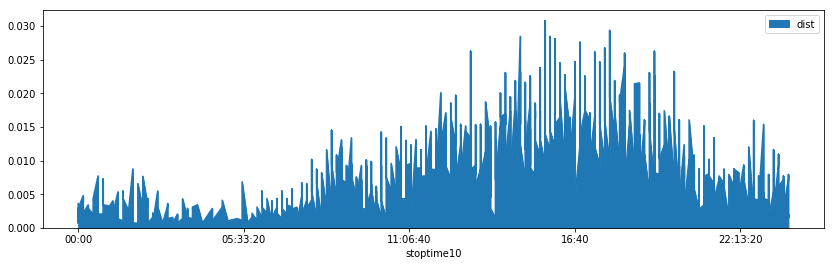

In [12]:
merge[merge["to_station_id"] == 2].plot(x="stoptime10", y="dist", figsize=(14,4), kind="area");

## Clustering (stop)

We cluster these distribution to find some patterns. But we need vectors of equal size which should be equal to 24*6.

In [13]:
print(key)
merge.groupby(key[:-1], as_index=False).count().head()

['to_station_id', 'to_station_name', 'stopweekday', 'stoptime10']


,to_station_id,to_station_name,stopweekday,stoptime10,nb_trips,nb_tripsday,dist
0,2,Michigan Ave & Balbo Ave,0,114,114,114,114
1,2,Michigan Ave & Balbo Ave,1,109,109,109,109
2,2,Michigan Ave & Balbo Ave,2,116,116,116,116
3,2,Michigan Ave & Balbo Ave,3,112,112,112,112
4,2,Michigan Ave & Balbo Ave,4,117,117,117,117


In [14]:
from ensae_projects.datainc.data_bikes import add_missing_time
full = df = add_missing_time(merge, delay=10, column="stoptime10", values=["nb_trips", "nb_tripsday", "dist"])
df.groupby(key[:-1], as_index=False).count().head()

,to_station_id,to_station_name,stopweekday,stoptime10,nb_trips,nb_tripsday,dist
0,2,Michigan Ave & Balbo Ave,0,144,144,144,144
1,2,Michigan Ave & Balbo Ave,1,144,144,144,144
2,2,Michigan Ave & Balbo Ave,2,144,144,144,144
3,2,Michigan Ave & Balbo Ave,3,144,144,144,144
4,2,Michigan Ave & Balbo Ave,4,144,144,144,144


This is much better.

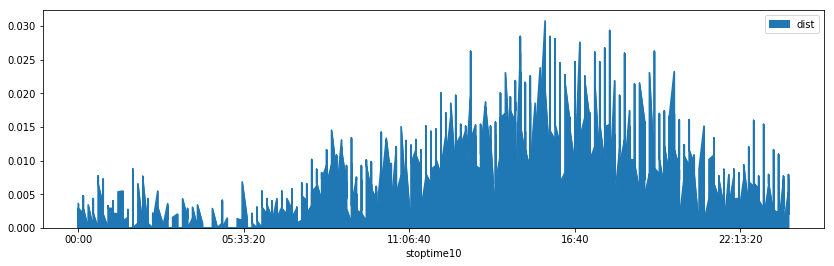

In [15]:
df[df["to_station_id"] == 2].plot(x="stoptime10", y="dist", figsize=(14,4), kind="area");

Let's build the features.

In [16]:
features = df.pivot_table(index=["to_station_id", "to_station_name", "stopweekday"],
                          columns="stoptime10", values="dist").reset_index()
features.head()

stoptime10,to_station_id,to_station_name,stopweekday,00:00:00,00:10:00,00:20:00,00:30:00,00:40:00,00:50:00,01:00:00,...,22:20:00,22:30:00,22:40:00,22:50:00,23:00:00,23:10:00,23:20:00,23:30:00,23:40:00,23:50:00
0,2,Michigan Ave & Balbo Ave,0,0.000000,0.002191,0.002191,0.002191,0.000000,0.000000,0.003286,...,0.004381,0.002191,0.004381,0.002191,0.004381,0.004381,0.005476,0.002191,0.000000,0.005476
1,2,Michigan Ave & Balbo Ave,1,0.000000,0.002677,0.000000,0.000000,0.001339,0.002677,0.000000,...,0.009371,0.012048,0.006693,0.004016,0.005355,0.006693,0.002677,0.000000,0.000000,0.000000
2,2,Michigan Ave & Balbo Ave,2,0.002907,0.002907,0.002907,0.004360,0.001453,0.007267,0.002907,...,0.002907,0.002907,0.015988,0.005814,0.001453,0.001453,0.011628,0.000000,0.000000,0.007267
3,2,Michigan Ave & Balbo Ave,3,0.000000,0.000000,0.000000,0.000000,0.007728,0.000000,0.001546,...,0.009274,0.003091,0.003091,0.007728,0.001546,0.003091,0.009274,0.001546,0.007728,0.001546
4,2,Michigan Ave & Balbo Ave,4,0.002053,0.000000,0.000000,0.002053,0.000000,0.002053,0.003080,...,0.008214,0.001027,0.006160,0.004107,0.015400,0.006160,0.002053,0.006160,0.007187,0.000000


In [17]:
names = features.columns[3:]
names

Index([00:00:00, 00:10:00, 00:20:00, 00:30:00, 00:40:00, 00:50:00, 01:00:00,
       01:10:00, 01:20:00, 01:30:00,
       ...
       22:20:00, 22:30:00, 22:40:00, 22:50:00, 23:00:00, 23:10:00, 23:20:00,
       23:30:00, 23:40:00, 23:50:00],
      dtype='object', name='stoptime10', length=144)

In [18]:
from sklearn.cluster import KMeans
clus = KMeans(8)
clus.fit(features[names])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
pred = clus.predict(features[names])
set(pred)

{0, 1, 2, 3, 4, 5, 6, 7}

In [20]:
features["cluster"] = pred

Let's see what it means accross day.

In [21]:
features[["cluster", "stopweekday", "to_station_id"]].groupby(["cluster", "stopweekday"]).count()

stoptime10           to_station_id
cluster stopweekday               
0       0                      304
        1                      348
        2                      337
        3                      315
        4                      275
        5                       36
        6                       46
1       0                        2
        1                        1
        2                        1
        6                        1
2       5                        2
3       0                        1
        2                        1
        3                        1
        4                        2
4       0                        1
        1                        1
        2                        1
        3                        1
5       0                        1
        6                        2
6       0                      123
        1                      133
        2                      143
        3                      137
        4                      147
        5                       13
        6                       11
7       0                      141
        1                       93
        2                       94
        3                      121
        4                      154
        5                      526
        6                      514

Let's draw the clusters.

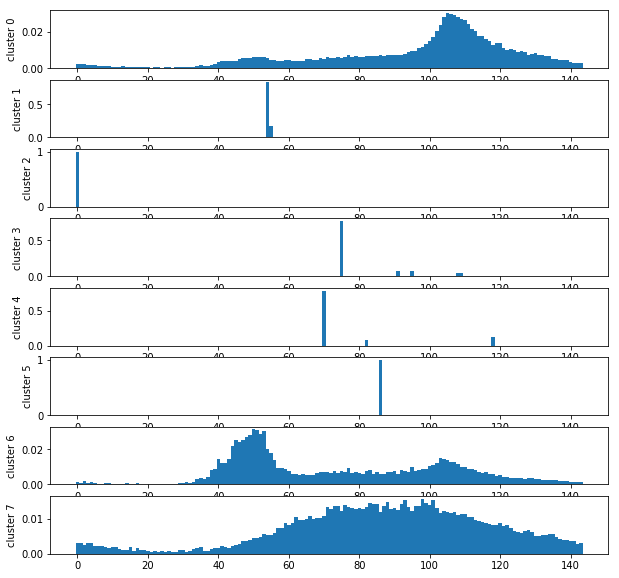

In [22]:
centers = clus.cluster_centers_.T
import matplotlib.pyplot as plt
fig, ax = plt.subplots(centers.shape[1], 1, figsize=(10,10))
x = list(range(0,centers.shape[0]))
for i in range(centers.shape[1]):
    ax[i].bar (x, centers[:,i], width=1.0)
    ax[i].set_ylabel("cluster %d" % i)

Three patterns emerge. However, small clusters are still annoying but let's show them on a map.

## Graph

We first need to get 7 clusters for each stations, one per day.

In [23]:
piv = features.pivot_table(index=["to_station_id","to_station_name"], columns="stopweekday", values="cluster")
piv.head()

,stopweekday,0,1,2,3,4,5,6
to_station_id,to_station_name,,,,,,,
2,Michigan Ave & Balbo Ave,7.0,0.0,7.0,7.0,7.0,7.0,7.0
3,Shedd Aquarium,7.0,7.0,7.0,7.0,7.0,7.0,7.0
4,Burnham Harbor,7.0,7.0,0.0,7.0,7.0,7.0,7.0
5,State St & Harrison St,0.0,0.0,0.0,0.0,0.0,7.0,7.0
6,Dusable Harbor,7.0,7.0,0.0,7.0,7.0,7.0,7.0


In [24]:
piv["distincts"] = piv.apply(lambda row: len(set(row[i] for i in range(0,7))), axis=1)

Let's see which station is classified in more than 4 clusters. NaN means no bikes stopped at this stations. They are mostly unused stations.

In [25]:
piv[piv.distincts >= 4]

,stopweekday,0,1,2,3,4,5,6,distincts
to_station_id,to_station_name,,,,,,,,
384,Halsted St & 51st St,NaN,7.0,7.0,7.0,0.0,0.0,6.0,4
386,Halsted St & 56th St,5.0,7.0,0.0,7.0,7.0,7.0,6.0,4
409,Shields Ave & 43rd St,7.0,NaN,7.0,NaN,6.0,0.0,7.0,5
530,Laramie Ave & Kinzie St,3.0,7.0,7.0,7.0,0.0,6.0,7.0,4
538,Cicero Ave & Flournoy St,7.0,6.0,NaN,6.0,7.0,7.0,5.0,4
543,Laramie Ave & Gladys Ave,0.0,7.0,6.0,6.0,6.0,6.0,NaN,4
548,Morgan St & Pershing Rd,NaN,7.0,7.0,6.0,0.0,7.0,0.0,4
556,Throop St & 52nd St,7.0,0.0,7.0,3.0,0.0,2.0,7.0,4
557,Damen Ave & Garfield Blvd,NaN,0.0,3.0,NaN,NaN,NaN,NaN,7


Let's draw a map on a week day.

In [26]:
data = stations.merge(piv.reset_index(), left_on=["id", "name"],
                      right_on=["to_station_id", "to_station_name"], suffixes=('', '_c'))
data.sort_values("id").head()

,id,name,latitude,longitude,dpcapacity,online_date,to_station_id,to_station_name,0,1,2,3,4,5,6,distincts
357,2,Michigan Ave & Balbo Ave,41.872638,-87.623979,35,5/8/2015,2,Michigan Ave & Balbo Ave,7.0,0.0,7.0,7.0,7.0,7.0,7.0,2
456,3,Shedd Aquarium,41.867226,-87.615355,31,4/24/2015,3,Shedd Aquarium,7.0,7.0,7.0,7.0,7.0,7.0,7.0,1
53,4,Burnham Harbor,41.856268,-87.613348,23,5/16/2015,4,Burnham Harbor,7.0,7.0,0.0,7.0,7.0,7.0,7.0,2
497,5,State St & Harrison St,41.874053,-87.627716,23,6/18/2013,5,State St & Harrison St,0.0,0.0,0.0,0.0,0.0,7.0,7.0,2
188,6,Dusable Harbor,41.885042,-87.612795,31,4/24/2015,6,Dusable Harbor,7.0,7.0,0.0,7.0,7.0,7.0,7.0,2


In [27]:
from ensae_projects.datainc.data_bikes import folium_html_stations_map

colors = ["blue", "red", "yellow", "gray", "green", "black", "brown"]
xy = []
for els in data.apply(lambda row: (row["latitude"], row["longitude"], row[1], row["name"]), axis=1):
    try:
        cl = int(els[2])
    except:
        # NaN
        continue
    name = "%s c%d" % (els[3], cl)
    color = colors[cl % len(colors)]
    xy.append( ( (els[0], els[1]), (name, color)))
folium_html_stations_map(xy, width="80%")

<pyensae.notebookhelper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x16204eba898>

We notice than people got to the park after work. Let's see during the week-end.

In [28]:
from ensae_projects.datainc.data_bikes import folium_html_stations_map

colors = ["blue", "red", "yellow", "gray", "green", "black", "brown"]
xy = []
for els in data.apply(lambda row: (row["latitude"], row["longitude"], row[5], row["name"]), axis=1):
    try:
        cl = int(els[2])
    except:
        # NaN
        continue
    name = "%s c%d" % (els[3], cl)
    color = colors[cl % len(colors)]
    xy.append( ( (els[0], els[1]), (name, color)))
folium_html_stations_map(xy, width="80%")

<pyensae.notebookhelper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x162056094a8>